## Week 1: Crypto Sentiment Data Collection
### Project 1 - Crypto Sentiment Classifier

GOALS FOR THIS WEEK:
1. Collect 1,000+ Bitcoin Reddit post
2. Get Bitcoin price data
3. Basic data exploration
4. Apply VADER sentiment (baseline)

#### Import and setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import requests
import time
from pathlib import Path

In [3]:
# For sentiment analysis baseline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create output directories if they don't exist
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/data/raw').mkdir(parents=True, exist_ok=True)
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/data/processed').mkdir(parents=True, exist_ok=True)
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/results').mkdir(parents=True, exist_ok=True)

print('✅ Set up complete!')

✅ Set up complete!


#### Collect Bitcoin price data

In [4]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
import yfinance as yf

def get_bitcoin_prices(days=30):
    """
    Fetch Bitcoin hourly price data using Yahoo Finance (yfinance).
    Always works worldwide, no API key, no region blocks.
    """

    print(f"📊 Fetching Bitcoin prices for last {days} days using Yahoo Finance...")

    btc = yf.Ticker("BTC-USD")

    try:
        # interval = '1h' for hourly data
        df = btc.history(period=f"{days}d", interval="1h")

        if df.empty:
            raise ValueError("Empty data returned.")

        df = df.reset_index()
        df = df[["Datetime", "Close"]]
        df.columns = ["timestamp", "price"]

        print(f"✅ Collected {len(df)} hourly price points")
        return df

    except Exception as e:
        print(f"❌ Error fetching prices: {e}")
        return None


# Run it!
btc_prices = get_bitcoin_prices(days=30)

if btc_prices is not None:
    print("\nFirst rows:")
    print(btc_prices.head())

    print("\nSummary stats:")
    print(btc_prices["price"].describe())

    btc_prices.to_csv("../data/raw/btc_prices.csv", index=False)
    print("💾 Saved to data/raw/btc_prices.csv")


📊 Fetching Bitcoin prices for last 30 days using Yahoo Finance...
✅ Collected 562 hourly price points

First rows:
                  timestamp          price
0 2025-11-11 00:00:00+00:00  106081.757812
1 2025-11-11 01:00:00+00:00  106045.328125
2 2025-11-11 02:00:00+00:00  106548.773438
3 2025-11-11 03:00:00+00:00  106437.601562
4 2025-11-11 04:00:00+00:00  105695.929688

Summary stats:
count       562.000000
mean      92018.590136
std        5389.049684
min       82228.773438
25%       87819.919922
50%       91333.292969
75%       94371.607422
max      106548.773438
Name: price, dtype: float64
💾 Saved to data/raw/btc_prices.csv


#### Visualize price data

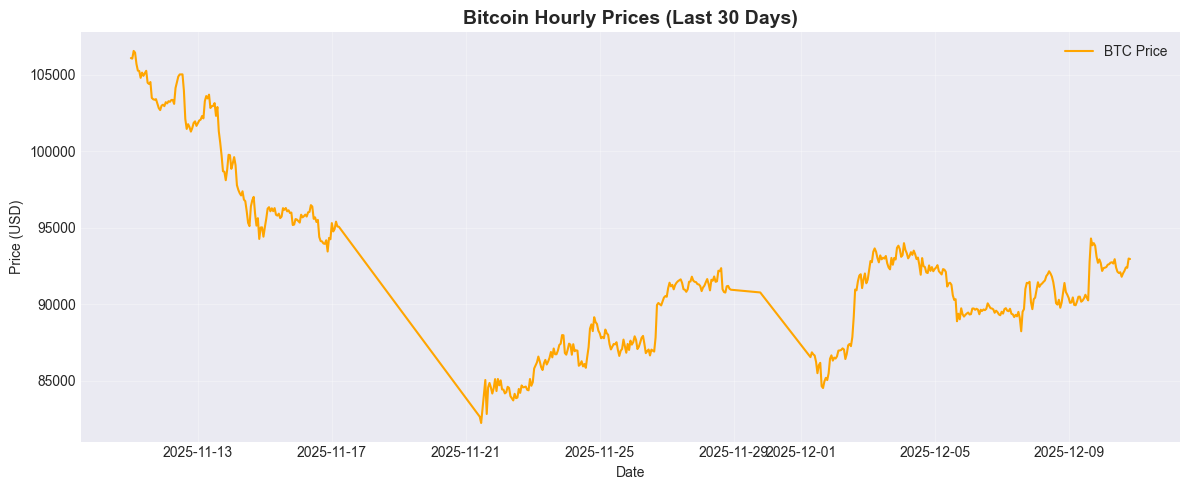

💾 Saved plot to results/btc_prices_plot.png


In [6]:
if btc_prices is not None:
    plt.figure(figsize=(12, 5))
    plt.plot(btc_prices['timestamp'], btc_prices['price'], label='BTC Price', color='orange')
    plt.title('Bitcoin Hourly Prices (Last 30 Days)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('../results/btc_prices_plot.png')
    plt.show()
    print("💾 Saved plot to results/btc_prices_plot.png")

#### Collect Twitter data using snscrape

In [ ]:
def collect_crypto_tweets_simple(keywords, max_tweets=1000, days_back=7, retry_attempts=3):
    """
    Collect tweets using snscrape with improved error handling and retry logic.
    
    Note: snscrape is unofficial and can be unstable. If it fails, consider:
    - Using alternative data sources (Reddit, news APIs, public datasets)
    - Trying again later (Twitter may be rate-limiting)
    - Using the sample data fallback
    """
    import snscrape.modules.twitter as sntwitter
    import random
    
    print(f"🐦 Collecting tweets about: {keywords}")
    print(f"   Max tweets: {max_tweets}, Days back: {days_back}")
    
    tweets_list = []

    # Build search query
    query = f"({' OR '.join(keywords)}) lang:en"
    since_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
    until_date = datetime.now().strftime('%Y-%m-%d')
    
    query_full = f"{query} since:{since_date} until:{until_date}"
    
    print(f"   Search query: {query_full}")
    print("   Collecting... (this may take a few minutes)")
    
    # Retry logic
    for attempt in range(retry_attempts):
        try:
            tweets_list = []  # Reset for each attempt
            
            for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query_full).get_items()):
                if i >= max_tweets:
                    break
                
                tweets_list.append({
                    'timestamp': tweet.date,
                    'text': tweet.rawContent,
                    'username': tweet.user.username,
                    'likes': tweet.likeCount,
                    'retweets': tweet.retweetCount,
                    'replies': tweet.replyCount,
                    'url': tweet.url
                })

                if (i + 1) % 100 == 0:
                    print(f"   Collected {i + 1} tweets...")
            
            if tweets_list:
                df = pd.DataFrame(tweets_list)
                print(f"✅ Collected {len(df)} tweets")
                return df
            else:
                raise ValueError("No tweets collected")
        
        except Exception as e:
            if attempt < retry_attempts - 1:
                wait_time = (attempt + 1) * 5 + random.uniform(0, 5)
                print(f"⚠️  Attempt {attempt + 1} failed: {str(e)[:100]}")
                print(f"   Retrying in {wait_time:.1f} seconds...")
                time.sleep(wait_time)
            else:
                print(f"❌ Error collecting tweets after {retry_attempts} attempts: {e}")
                print("   Note: snscrape can be unstable. Consider using alternative data sources.")
                return None
    
    return None

# Collect tweets - Start small to test!
crypto_keywords = ['#Bitcoin', '#BTC', '$BTC', '#Crypto']

tweets_df = collect_crypto_tweets_simple(
    keywords=crypto_keywords,
    max_tweets=500,  # Start with 500 to test
    days_back=7
)

🐦 Collecting tweets about: ['#Bitcoin', '#BTC', '$BTC', '#Crypto']
   Max tweets: 500, Days back: 7
   Search query: (#Bitcoin OR #BTC OR $BTC OR #Crypto) lang:en since:2025-12-01 until:2025-12-08
   Collecting... (this may take a few minutes)


Error retrieving https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22%28%23Bitcoin%20OR%20%23BTC%20OR%20%24BTC%20OR%20%23Crypto%29%20lang%3Aen%20since%3A2025-12-01%20until%3A2025-12-08%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%2

❌ Error collecting tweets: 4 requests to https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22%28%23Bitcoin%20OR%20%23BTC%20OR%20%24BTC%20OR%20%23Crypto%29%20lang%3Aen%20since%3A2025-12-01%20until%3A2025-12-08%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_ap

#### Import Bitcoin Data

In [11]:
# Import Bitcoin Reddit data

print("📂 Loading Bitcoin Reddit data...")

# Load the CSV file
df = pd.read_csv('../Bitcoin_data_991.csv')

print(f"✅ Loaded {len(df)} Reddit posts")
print(f"\n📊 Dataset Info:")
print(f"   Columns: {list(df.columns)}")
print(f"   Shape: {df.shape}")

# Combine title and body into a single text column
df['text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')
df['text'] = df['text'].str.strip()

# Convert Unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')

# Rename columns to match expected format
df = df.rename(columns={
    'score': 'likes',
    'upvote_ratio': 'upvote_ratio'
})

# Select relevant columns
reddit_df = df[['timestamp', 'text', 'likes', 'url', 'subreddit']].copy()

# Add placeholder columns for compatibility with existing code
reddit_df['username'] = 'reddit_user'
reddit_df['retweets'] = 0
reddit_df['replies'] = 0

print(f"\n📝 Preview of data:")
print(reddit_df[['timestamp', 'text', 'likes']].head())
print(f"\n📊 Text length stats:")
print(f"   Min: {reddit_df['text'].str.len().min()} chars")
print(f"   Max: {reddit_df['text'].str.len().max()} chars")
print(f"   Mean: {reddit_df['text'].str.len().mean():.0f} chars")
print(f"\n💾 Data ready for preprocessing!")

📂 Loading Bitcoin Reddit data...
✅ Loaded 991 Reddit posts

📊 Dataset Info:
   Columns: ['id', 'title', 'body', 'subreddit', 'score', 'upvote_ratio', 'url', 'created_utc']
   Shape: (991, 8)

📝 Preview of data:
            timestamp                                               text  \
0 2025-12-10 19:30:51  Your favorite bitcoin characters found a new w...   
1 2025-12-10 18:56:18  Your Daily Bitcoin Breakdown newsletter is now...   
2 2025-12-10 18:56:09  Your Daily Bitcoin Breakdown newsletter is now...   
3 2025-12-10 18:54:59  What photo should I use as my discord logo? I ...   
4 2025-12-10 18:54:39  What photo should I use as my discord logo? I ...   

   likes  
0      1  
1      0  
2      0  
3      0  
4      0  

📊 Text length stats:
   Min: 1 chars
   Max: 9911 chars
   Mean: 436 chars

💾 Data ready for preprocessing!


#### Basic text preprocessing

In [12]:
def clean_text(text):
    """
    Comprehensive text cleaning for Reddit posts:
    - Remove URLs
    - Remove Reddit-specific formatting (markdown links, etc.)
    - Remove extra whitespace
    - Handle NaN values
    """
    import re
    
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string if not already
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove Reddit markdown links [text](url) -> text
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)
    
    # Remove Reddit image/video links
    text = re.sub(r'https://preview\.redd\.it/\S+', '', text)
    text = re.sub(r'https://i\.redd\.it/\S+', '', text)
    
    # Remove HTML entities
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    text = re.sub(r'&quot;', '"', text)
    
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

# Apply text cleaning
if 'reddit_df' in locals() and reddit_df is not None:
    print("🧹 Cleaning text data...")
    
    # Apply cleaning function
    reddit_df['text_cleaned'] = reddit_df['text'].apply(clean_text)
    
    # Remove rows with empty text after cleaning
    initial_count = len(reddit_df)
    reddit_df = reddit_df[reddit_df['text_cleaned'].str.len() > 0].copy()
    removed_count = initial_count - len(reddit_df)
    
    print(f"✅ Text cleaning complete!")
    print(f"   Removed {removed_count} empty posts")
    print(f"   Remaining: {len(reddit_df)} posts")
    
    print("\n📝 CLEANED TEXT EXAMPLES:")
    print("=" * 70)
    for i in range(min(5, len(reddit_df))):
        original = reddit_df.iloc[i]['text'][:100] + '...' if len(reddit_df.iloc[i]['text']) > 100 else reddit_df.iloc[i]['text']
        cleaned = reddit_df.iloc[i]['text_cleaned'][:100] + '...' if len(reddit_df.iloc[i]['text_cleaned']) > 100 else reddit_df.iloc[i]['text_cleaned']
        print(f"\n[{i+1}] Original ({len(reddit_df.iloc[i]['text'])} chars):")
        print(f"    {original}")
        print(f"    Cleaned ({len(reddit_df.iloc[i]['text_cleaned'])} chars):")
        print(f"    {cleaned}")
    
    # Save cleaned data
    reddit_df.to_csv('../data/raw/crypto_reddit_raw.csv', index=False)
    print(f"\n💾 Saved cleaned data to data/raw/crypto_reddit_raw.csv")
else:
    print("⚠️  No data loaded. Please run the import cell first.")

🧹 Cleaning text data...
✅ Text cleaning complete!
   Removed 0 empty posts
   Remaining: 991 posts

📝 CLEANED TEXT EXAMPLES:

[1] Original (164 chars):
    Your favorite bitcoin characters found a new world The only bitcoin IG account that is guaranteed to...
    Cleaned (164 chars):
    Your favorite bitcoin characters found a new world The only bitcoin IG account that is guaranteed to...

[2] Original (170 chars):
    Your Daily Bitcoin Breakdown newsletter is now live. Check out today’s Top Stories and a sneak peek ...
    Cleaned (170 chars):
    Your Daily Bitcoin Breakdown newsletter is now live. Check out today’s Top Stories and a sneak peek ...

[3] Original (170 chars):
    Your Daily Bitcoin Breakdown newsletter is now live. Check out today’s Top Stories and a sneak peek ...
    Cleaned (170 chars):
    Your Daily Bitcoin Breakdown newsletter is now live. Check out today’s Top Stories and a sneak peek ...

[4] Original (458 chars):
    What photo should I use as my discord lo

#### Apply VADER sentiment baseline

In [13]:
"""
VADER = Valence Aware Dictionary and sEntiment Reasoner
Good baseline for social media text, understands emojis and caps!
"""

def get_vader_sentiments(text):
    """
    Apply VADER sentiment analysis to tweets DataFrame.
    Returns compound score (-1 to +1)
    """
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores

if reddit_df is not None:
    print("\n🎭 APPLYING VADER SENTIMENT ANALYSIS")
    print("=" * 50)

    analyzer = SentimentIntensityAnalyzer()

    # apply to all reddit posts
    vader_scores = reddit_df['text_cleaned'].apply(get_vader_sentiments)

    # Extract scores
    reddit_df['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
    reddit_df['vader_neu'] = vader_scores.apply(lambda x: x['neu'])
    reddit_df['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
    reddit_df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])
    
    # Create sentiment label
    def sentiment_label(compound):
        if compound >= 0.05:
            return 'positive'
        elif compound <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    reddit_df['sentiment'] = reddit_df['vader_compound'].apply(sentiment_label)
    
    print("\n📊 SENTIMENT DISTRIBUTION:")
    print(reddit_df['sentiment'].value_counts())
    
    print("\n📝 EXAMPLE SENTIMENTS:")
    print("=" * 50)

    # Show examples from each category
    for sentiment_type in ['positive', 'negative', 'neutral']:
        example = reddit_df[reddit_df['sentiment'] == sentiment_type].iloc[0]
        print(f"\n{sentiment_type.upper()}: {example['text_cleaned']}")
        print(f"  Score: {example['vader_compound']:.3f}")


🎭 APPLYING VADER SENTIMENT ANALYSIS

📊 SENTIMENT DISTRIBUTION:
sentiment
positive    558
neutral     242
negative    191
Name: count, dtype: int64

📝 EXAMPLE SENTIMENTS:

POSITIVE: Your favorite bitcoin characters found a new world The only bitcoin IG account that is guaranteed to never raise your IQ even a fraction of a point: bittyandbuddies
  Score: 0.459

NEGATIVE: Can gov track my reddit account? In my country crypto is illegal and i’ve active on many crypto servers and was wondering if gov can track my Reddit account or nkt?
  Score: -0.309

NEUTRAL: Daily Meme Until $100,000
  Score: 0.000


#### Visualize sentiment distribution

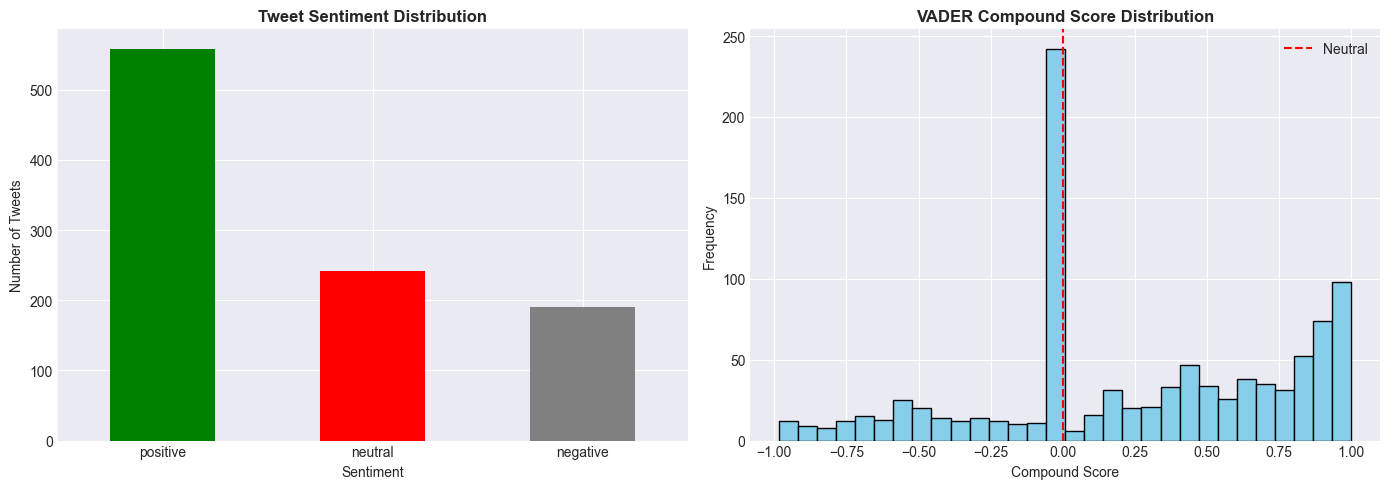


✅ Saved to results/sentiment_distribution.png


In [14]:
if reddit_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sentiment counts
    reddit_df['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
    axes[0].set_title('Tweet Sentiment Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Number of Tweets')
    axes[0].tick_params(axis='x', rotation=0)

    # Compound score distribution
    axes[1].hist(reddit_df['vader_compound'], bins=30, color='skyblue', edgecolor='black')
    axes[1].set_title('VADER Compound Score Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Compound Score')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(x=0, color='red', linestyle='--', label='Neutral')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../results/sentiment_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved to results/sentiment_distribution.png")


#### Save processed data

In [16]:
if reddit_df is not None:
    # Save processed posts with sentiment
    reddit_df.to_csv('../data/processed/reddit_with_sentiment.csv', index=False)
    print("\n💾 Saved processed data to data/processed/reddit_with_sentiment.csv")
    
    # Create a summary report
    summary = {
        'collection_date': datetime.now().isoformat(),
        'total_posts': len(reddit_df),
        'date_range': {
            'start': reddit_df['timestamp'].min().isoformat(),
            'end': reddit_df['timestamp'].max().isoformat()
        },
        'sentiment_distribution': reddit_df['sentiment'].value_counts().to_dict(),
        'avg_sentiment_score': float(reddit_df['vader_compound'].mean()),
        'data_source': 'Bitcoin_data_991.csv'
    }
    
    with open('../data/processed/collection_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("💾 Saved summary to data/processed/collection_summary.json")


💾 Saved processed data to data/processed/reddit_with_sentiment.csv
💾 Saved summary to data/processed/collection_summary.json


#### Week 1 summary and next steps

In [17]:
print("\n" + "=" * 70)
print("🎉 WEEK 1 COMPLETE! HERE'S WHAT WE DID:")
print("=" * 70)

if btc_prices is not None:
    print(f"✅ Collected {len(btc_prices)} Bitcoin price points")

if reddit_df is not None:
    print(f"✅ Collected {len(reddit_df)} crypto posts")
    print(f"✅ Applied VADER sentiment analysis")
    print(f"✅ Created baseline sentiment labels")
    print(f"✅ Generated visualizations")

print("\n" + "=" * 70)


🎉 WEEK 1 COMPLETE! HERE'S WHAT WE DID:
✅ Collected 562 Bitcoin price points
✅ Collected 991 crypto posts
✅ Applied VADER sentiment analysis
✅ Created baseline sentiment labels
✅ Generated visualizations

